In [ ]:
%matplotlib inline


Data Loading and Processing Tutorial
====================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

A lot of effort in solving any machine learning problem goes in to
preparing the data. PyTorch provides many tools to make data loading
easy and hopefully, to make your code more readable. In this tutorial,
we will see how to load and preprocess/augment data from a non trivial
dataset.

To run this tutorial, please make sure the following packages are
installed:

-  ``scikit-image``: For image io and transforms
-  ``pandas``: For easier csv parsing




In [5]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

The dataset we are going to deal with is that of facial pose.
This means that a face is annotated like this:

.. figure:: /_static/img/landmarked_face2.png
   :width: 400

Over all, 68 different landmark points are annotated for each face.

<div class="alert alert-info"><h4>Note</h4><p>Download the dataset from `here <https://download.pytorch.org/tutorial/faces.zip>`_
    so that the images are in a directory named 'faces/'.
    This dataset was actually
    generated by applying excellent `dlib's pose
    estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`__
    on a few images from imagenet tagged as 'face'.</p></div>

Dataset comes with a csv file with annotations which looks like this:

::

    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

Let's quickly read the CSV and get the annotations in an (N, 2) array where N
is the number of landmarks.




In [6]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Let's write a simple helper function to show an image and its landmarks
and use it to show a sample.




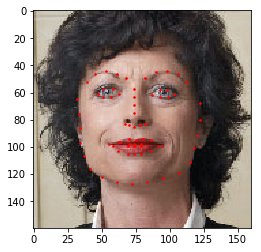

In [22]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'landmarks': landmarks}``. Our datset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.




In [8]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Let's instantiate this class and iterate through the data samples. We
will print the sizes of first 4 samples and show their landmarks.




0 (324, 215, 3) (68, 2)


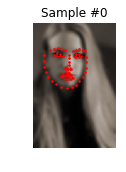

1 (500, 333, 3) (68, 2)


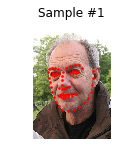

2 (250, 258, 3) (68, 2)


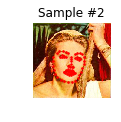

3 (434, 290, 3) (68, 2)


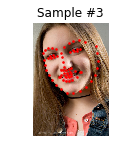

In [9]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Transforms
----------

One issue we can see from the above is that the samples are not of the
same size. Most neural networks expect the images of a fixed size.
Therefore, we will need to write some prepocessing code.
Let's create three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and
if required, ``__init__`` method. We can then use a transform like this:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

Observe below how these transforms had to be applied both on the image and
landmarks.




In [12]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        # from which position at the top should we start (pick randomly)
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

0 (324, 215, 3) (68, 2)


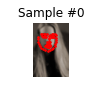

0 (200, 200, 3) (68, 2)


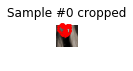

1 (500, 333, 3) (68, 2)


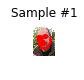

1 (200, 200, 3) (68, 2)


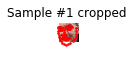

2 (250, 258, 3) (68, 2)


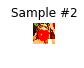

2 (200, 200, 3) (68, 2)


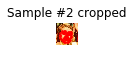

3 (434, 290, 3) (68, 2)


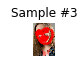

3 (200, 200, 3) (68, 2)


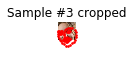

In [14]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()
crop = RandomCrop(200)

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 8, 2*i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    sample = crop(sample)
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 8, 2*i + 2)
    plt.tight_layout()
    ax.set_title('Sample #{} cropped'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    

    if i == 3:
        plt.show()
        break

Compose transforms
~~~~~~~~~~~~~~~~~~

Now, we apply the transforms on an sample.

Let's say we want to rescale the shorter side of the image to 256 and
then randomly crop a square of size 224 from it. i.e, we want to compose
``Rescale`` and ``RandomCrop`` transforms.
``torchvision.transforms.Compose`` is a simple callable class which allows us
to do this.




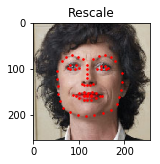

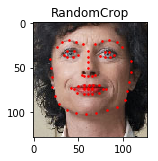

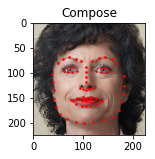

In [15]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

Iterating through the dataset
-----------------------------

Let's put this all together to create a dataset with composed
transforms.
To summarize, every time this dataset is sampled:

-  An image is read from the file on the fly
-  Transforms are applied on the read image
-  Since one of the transforms is random, data is augmentated on
   sampling

We can iterate over the created dataset with a ``for i in range``
loop as before.




0


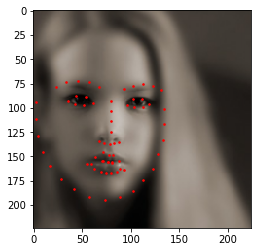

1


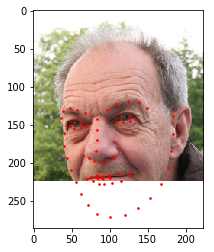

2


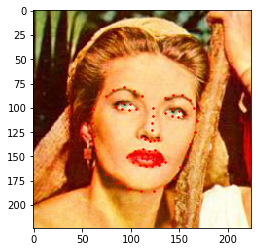

3


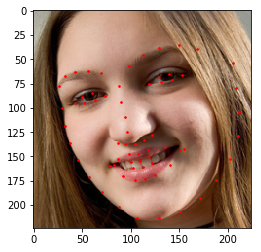

In [36]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224)
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    # print("type of sample: ", type(sample))
    # help(sample)
    # dir(sample)
    print(i)
    # print(sample['image'])
    # print(sample['landmarks'])
    show_landmarks(**sample)
    if i == 3:
        break

In [37]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple ``for`` loop to
iterate over the data. In particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases.




Length of the transformed dataset:  69
dir of the transformed dataset:  ['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'landmarks_frame', 'root_dir', 'transform']
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
batch size:  4
images_batch size:  torch.Size([4, 3, 224, 224])


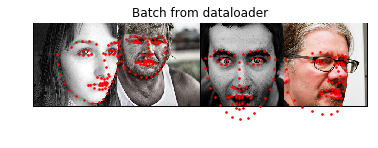

In [44]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

print("Length of the transformed dataset: ", len(transformed_dataset))
print("dir of the transformed dataset: ", dir(transformed_dataset))

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    print("batch size: ", batch_size)
    print("images_batch size: ", images_batch.size())
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    # the channel is on the last position for images in python
    plt.imshow(grid.numpy().transpose((1, 2, 0))) 

    for i in range(batch_size):
        # shift landmarks to their correct position for each picture: i * im_size
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Afterword: torchvision
In this tutorial, we have seen how to write and use datasets, transforms and dataloader. torchvision package provides some common datasets and transforms. You might not even have to write custom classes. One of the more generic datasets available in torchvision is ImageFolder. It assumes that images are organized in the following way:

```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```
where ‘ants’, ‘bees’ etc. are class labels. Similarly generic transforms which operate on PIL.Image like RandomHorizontalFlip, Scale, are also avaiable. You can use these to write a dataloader like this:

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)

In [65]:
for i in range(5):
    print(hymenoptera_dataset[i])

for i in range(5):
    print(hymenoptera_dataset[-i])

(tensor([[[ 1.3413,  1.2557,  0.9817,  ..., -1.7240, -1.7412, -1.6898],
         [ 1.3413,  1.1187,  0.8618,  ..., -1.7240, -1.7240, -1.6898],
         [ 1.3413,  1.0673,  0.8104,  ..., -1.6555, -1.6727, -1.6384],
         ...,
         [-0.3198, -0.3369, -0.2342,  ..., -2.0494, -2.0665, -2.0494],
         [-0.4568, -0.4226, -0.3027,  ..., -2.0494, -2.0665, -2.0665],
         [-0.3541, -0.3883, -0.2856,  ..., -1.8610, -2.0494, -2.0665]],

        [[ 1.5882,  1.4307,  1.0630,  ..., -1.3704, -1.4055, -1.4055],
         [ 1.6057,  1.3957,  1.1506,  ..., -1.4055, -1.3880, -1.4055],
         [ 1.6408,  1.4307,  1.1856,  ..., -1.3704, -1.3880, -1.3880],
         ...,
         [-0.3025, -0.2850, -0.2325,  ..., -1.7906, -1.8256, -1.8081],
         [-0.2675, -0.2150, -0.2500,  ..., -1.7556, -1.8081, -1.8081],
         [-0.2500, -0.3025, -0.3025,  ..., -1.4755, -1.7381, -1.7906]],

        [[ 2.1171,  2.0125,  1.5420,  ..., -0.9678, -0.9853, -1.1247],
         [ 2.1171,  2.0648,  1.5245,  ..., -

size of the dataset: 61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0
labels:  tensor([ 1,  1,  1,  1])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-1.7925, -1.8097, -1.8439,  ..., -1.4843, -1.5528, -1.5528],
        [-1.8439, -1.8439, -1.8610,  ..., -1.5185, -1.5699, -1.5528],
        [-1.8268, -1.8268, -1.8268,  ..., -1.5357, -1.5357, -1.5014],
        ...,
        [-0.7822, -0.8335, -0.7308,  ..., -2.0323, -2.0665, -2.0665],
        [-0.8164, -0.7479, -0.7137,  ..., -2.0323, -2.0323, -2.0323],
        [-0.9877, -0.8335, -0.8164,  ..., -2.0323, -2.0494, -2.0323]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.3883, -0.3712, -0.3712,  ..., -0.2342, -0.1657, -0.0801],
        [-0.3198, -0.3369, -0.2684,  ..., -0.2171, -0.1486, -0.0629],
        [-0.1999, -0.2856, -0.2856,  ..., -0.1486, -0.0972, -0.0458],
        ...,
        [-0.2171, -0.2513, -0.3027,  ...,  1.2728,  1.1358,  1.0159],
        [-0.2342, -0.1657, -0.1657,  ...,  1.3755,  1.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


0
labels:  tensor([ 1,  1,  1,  1])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.9064,  1.8893,  1.8550,  ..., -0.1314, -0.1314, -0.1657],
        [ 1.9578,  1.9235,  1.8893,  ..., -0.1486, -0.1486, -0.1486],
        [ 1.9749,  1.9749,  1.9235,  ..., -0.1314, -0.1314, -0.1314],
        ...,
        [ 1.9578,  1.9920,  1.9749,  ..., -2.0837, -2.1008, -2.1179],
        [ 1.9064,  1.9749,  1.9578,  ..., -2.0837, -2.1008, -2.0837],
        [ 1.8893,  1.9407,  1.9407,  ..., -2.0837, -2.0665, -1.9980]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.3413,  1.1872,  0.9988,  ...,  1.8722,  1.7352,  2.1804],
        [ 1.2899,  1.1015,  0.9988,  ...,  1.9407,  1.8550,  2.1804],
        [ 1.2214,  1.0673,  0.9988,  ...,  2.0263,  2.1462,  2.2147],
        ...,
        [ 0.8618,  0.9303,  0.9988,  ...,  1.7009,  1.9920,  2.1633],
        [ 0.6392,  0.7077,  0.8104,  ...,  1.8550,  1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 0.6049,  0.5536,  0.5193,  ...,  0.8276,  0.8961,  0.9474],
        [ 0.5878,  0.5364,  0.5022,  ...,  0.8104,  0.9474,  1.0159],
        [ 0.5878,  0.5536,  0.5364,  ...,  0.8789,  0.9988,  1.0159],
        ...,
        [-1.5357, -1.6213, -1.6727,  ...,  1.1187,  1.1187,  1.1529],
        [-1.5357, -1.6213, -1.6727,  ...,  1.1187,  1.1358,  1.1529],
        [-1.5699, -1.6213, -1.6727,  ...,  1.1529,  1.1358,  1.1358]])
0
labels:  tensor([ 1,  1,  1,  1])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.9920,  1.9749,  1.9749,  ..., -1.6384, -1.6555, -1.6384],
        [ 1.9920,  1.9920,  1.9920,  ..., -1.6384, -1.6384, -1.6384],
        [ 2.0092,  2.0092,  2.0092,  ..., -1.6555, -1.6384, -1.6384],
        ...,
        [-0.4739, -0.4911, -0.4739,  ..., -0.5253, -0.4226, -0.2856],
        [-0.4739, -0.4911, -0.4739,  ..., -0.6623, -0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0
labels:  tensor([ 1,  1,  1,  1])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.0801, -0.0801, -0.0801,  ..., -0.1486, -0.1657, -0.1657],
        [-0.0801, -0.0801, -0.0801,  ..., -0.1828, -0.1828, -0.1999],
        [-0.0629, -0.0458, -0.0458,  ..., -0.2171, -0.2171, -0.2171],
        ...,
        [-1.6042, -1.5357, -1.5528,  ..., -0.1314, -0.1828, -0.1999],
        [-1.5185, -1.5870, -1.5699,  ..., -0.1486, -0.1657, -0.1657],
        [-1.5357, -1.6042, -1.5528,  ..., -0.1486, -0.1657, -0.1657]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.0287, -0.0116,  0.0056,  ...,  1.2557,  1.2557,  1.2899],
        [ 0.0912,  0.1083,  0.0227,  ...,  1.3070,  1.3070,  1.3242],
        [ 0.0227,  0.0056, -0.0116,  ...,  1.3584,  1.3927,  1.3927],
        ...,
        [ 0.5878,  0.5707,  0.5707,  ...,  2.2318,  2.2147,  2.2147],
        [ 0.6049,  0.5707,  0.5536,  ...,  2.1975,  2.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([[-0.1314, -0.1143, -0.1143,  ..., -1.4843, -1.4843, -1.4843],
        [-0.0801, -0.0629, -0.0972,  ..., -1.5014, -1.4843, -1.4843],
        [-0.0116, -0.0458, -0.0801,  ..., -1.5357, -1.5014, -1.5014],
        ...,
        [ 1.1529,  1.1700,  1.1700,  ..., -0.2342, -0.0287,  0.7248],
        [ 1.2214,  1.2385,  1.3070,  ...,  0.0569,  0.2796,  0.8789],
        [ 1.3070,  1.3413,  1.3413,  ...,  0.5536,  0.6734,  1.3413]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.9192, -0.9192, -0.9534,  ..., -1.1418, -1.1247, -1.1075],
        [-0.9705, -0.9877, -0.9705,  ..., -1.1247, -1.1418, -1.1418],
        [-0.9877, -0.9534, -0.9877,  ..., -1.1075, -1.1589, -1.1418],
        ...,
        [-1.1418, -1.2274, -1.2788,  ..., -1.5870, -1.5699, -1.5699],
        [-1.1589, -1.1760, -1.2274,  ..., -1.6042, -1.5699, -1.5870],
        [-1.1760, -1.1932, -1.2274,  ..., -1.5528, -1.5528, -1.6042]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([[-1.1760, -1.2103, -1.2274,  ..., -1.2617, -1.2617, -1.2103],
        [-1.2103, -1.2274, -1.2274,  ..., -1.2617, -1.3130, -1.2617],
        [-1.2103, -1.1589, -1.1760,  ..., -1.2959, -1.2959, -1.2617],
        ...,
        [-1.1932, -1.2445, -1.2617,  ...,  0.9646,  0.9817,  1.0159],
        [-1.2445, -1.2788, -1.2617,  ...,  1.0502,  1.0673,  1.0844],
        [-1.2788, -1.2445, -1.2103,  ...,  1.0673,  1.0502,  1.1187]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-1.7240, -1.7240, -1.7240,  ..., -1.2788, -1.3130, -1.2959],
        [-1.7069, -1.7069, -1.7069,  ..., -1.3130, -1.3130, -1.2617],
        [-1.7069, -1.7069, -1.7069,  ..., -1.3130, -1.3130, -1.2788],
        ...,
        [-1.8097, -1.7754, -1.7583,  ..., -0.3198, -0.3541, -0.3883],
        [-1.8097, -1.7925, -1.7754,  ..., -0.3198, -0.3541, -0.3712],
        [-1.8097, -1.7754, -1.7583,  ..., -0.3369, -0.3369, -0.3712]])
0
labels:  tensor([ 1,  1,  1,  1])
number of images in a si

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([[-0.0287, -0.0458, -0.0629,  ..., -0.3712, -0.3883, -0.3712],
        [-0.0972, -0.1143, -0.1486,  ..., -0.3712, -0.3883, -0.3541],
        [-0.1657, -0.1828, -0.2171,  ..., -0.3712, -0.3712, -0.3541],
        ...,
        [-0.2171, -0.2342, -0.2342,  ..., -1.2274, -0.9877, -0.8164],
        [-0.1999, -0.1999, -0.2171,  ..., -1.1760, -1.2274, -1.0219],
        [-0.1828, -0.1999, -0.2171,  ..., -1.1589, -1.3473, -1.1418]])
0
labels:  tensor([ 1,  1,  1,  1])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 0.8618,  0.3652, -0.8164,  ...,  0.4337,  0.6049,  0.7591],
        [ 0.6906, -0.1143, -1.3473,  ...,  0.3823,  0.5707,  0.7077],
        [ 0.3823, -0.7308, -1.5870,  ...,  0.3309,  0.5022,  0.6392],
        ...,
        [-0.7993, -0.8678, -0.8849,  ..., -1.9467, -1.9467, -1.9809],
        [-0.8849, -1.0219, -0.7822,  ..., -1.9467, -1.9638, -1.9638],
        [-0.8678, -0.9877, -0.9020,  ..., -1.9467, -1.963

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([[-0.0458,  0.0912,  0.2967,  ..., -1.5357, -1.5357, -1.5357],
        [-0.0287,  0.0912,  0.2967,  ..., -1.4672, -1.4843, -1.5014],
        [ 0.0227,  0.1083,  0.2796,  ..., -1.3302, -1.3987, -1.4329],
        ...,
        [-1.3644, -1.3473, -1.3473,  ..., -0.3198, -0.5596, -0.7137],
        [-1.2445, -1.2445, -1.2445,  ..., -0.3027, -0.5767, -0.7650],
        [-1.1932, -1.1932, -1.2103,  ..., -0.3027, -0.5938, -0.7822]])
0
labels:  tensor([ 1,  1,  1,  1])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 2.0263,  2.0434,  2.0605,  ...,  2.0434,  2.0777,  2.0948],
        [ 2.0434,  2.0605,  2.0605,  ...,  2.0434,  2.0605,  2.0777],
        [ 2.0434,  2.0605,  2.0605,  ...,  2.0434,  2.0605,  2.0948],
        ...,
        [ 0.7419,  0.5193,  0.4508,  ...,  1.5297,  1.5468,  1.5468],
        [ 0.7077,  0.3994,  0.3823,  ...,  1.5125,  1.4954,  1.4783],
        [ 1.0502,  0.8961,  0.8618,  ...,  1.4783,  1.461

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([[ 2.2489,  2.1804,  2.1290,  ...,  2.2489,  2.2489,  2.2489],
        [ 2.2318,  2.0948,  2.1290,  ...,  2.2489,  2.2489,  2.2489],
        [ 2.1290,  2.2147,  2.1804,  ...,  2.2489,  2.2489,  2.2489],
        ...,
        [ 1.7009,  1.5810,  1.7180,  ...,  2.2489,  2.2489,  2.2489],
        [ 1.8550,  1.5639,  1.6324,  ...,  2.2489,  2.2489,  2.2489],
        [ 1.9407,  1.5982,  1.5982,  ...,  2.2489,  2.2489,  2.2489]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.0287, -0.9020, -1.4843,  ..., -0.0972, -0.1486, -0.1999],
        [-0.2171, -1.0733, -1.5357,  ..., -0.1314, -0.1828, -0.2513],
        [-0.5082, -1.3473, -1.6213,  ..., -0.1828, -0.2342, -0.3369],
        ...,
        [-0.6965, -0.7137, -0.7479,  ..., -0.3541, -0.3883, -0.4397],
        [-0.7308, -0.7479, -0.7822,  ..., -0.3198, -0.3883, -0.4568],
        [-0.7650, -0.7822, -0.7993,  ..., -0.3027, -0.3883, -0.4568]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

labels:  tensor([ 1,  0,  0,  0])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.5596,  0.0227,  0.4851,  ...,  0.4508,  0.8789,  0.7762],
        [-0.5938, -0.0287,  0.1254,  ...,  0.2624,  0.3652,  1.0331],
        [-1.0390, -0.4568, -0.1486,  ...,  0.0227,  0.1083,  0.8961],
        ...,
        [-0.2856, -1.0904, -1.0562,  ...,  0.3652,  0.0912,  0.7248],
        [-0.4739, -1.2274, -0.6281,  ...,  0.1939, -0.1143, -0.5253],
        [-0.7822, -1.1247,  0.2967,  ...,  0.2282, -0.2513, -1.0048]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-1.4158, -1.0904, -0.0287,  ..., -1.2617, -0.7137, -0.4911],
        [-1.0733, -0.5767,  0.2967,  ..., -1.3815, -0.6965, -0.4054],
        [-0.5938,  0.0227,  0.7248,  ..., -1.5014, -0.8507, -0.4911],
        ...,
        [ 1.4612,  1.3927,  1.2214,  ..., -0.8849, -0.4911, -0.4397],
        [ 1.4783,  1.3242,  1.2214,  ..., -0.9363, -0.593

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


labels:  tensor([ 0,  0,  0,  0])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.5810,  1.5468,  1.4783,  ..., -1.3130, -1.2274, -0.6281],
        [ 1.5982,  1.5468,  1.4954,  ..., -1.2274, -1.1418, -0.7137],
        [ 1.5639,  1.5468,  1.4783,  ..., -1.2617, -1.1589, -0.8507],
        ...,
        [-0.5253, -0.5424, -0.7650,  ..., -1.1075, -1.2103, -1.2617],
        [-0.5253, -0.5253, -0.6623,  ..., -0.9877, -1.1418, -1.2274],
        [-0.4568, -0.5253, -0.6794,  ..., -1.0562, -1.2959, -1.0219]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.9749,  2.1290,  2.2147,  ...,  2.2318,  1.8379,  1.2043],
        [ 1.4612,  1.6324,  1.8893,  ...,  1.4783,  1.4440,  1.3413],
        [ 1.1358,  1.3755,  1.7009,  ...,  1.1358,  1.1358,  1.2043],
        ...,
        [ 0.5364,  0.7591,  1.2728,  ...,  1.1358,  1.0159,  1.1529],
        [ 0.8618,  0.7591,  1.0331,  ...,  1.2043,  1.32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0
labels:  tensor([ 0,  0,  0,  0])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.5639,  1.1187,  1.0159,  ...,  1.5297,  1.8550,  1.7865],
        [ 1.7352,  1.5297,  1.2728,  ...,  0.4166,  0.5193,  1.1358],
        [ 1.5468,  1.6324,  1.3242,  ...,  0.5193,  0.1254,  0.9817],
        ...,
        [ 1.8037,  1.6324,  1.5125,  ...,  1.6495,  1.6838,  1.6667],
        [ 1.7180,  1.6838,  1.5297,  ...,  1.4440,  1.5125,  1.5125],
        [ 1.6324,  1.8208,  1.6495,  ...,  1.4954,  1.5810,  1.5810]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.2513, -0.3883, -0.2171,  ..., -0.9877, -0.8849, -0.5082],
        [-0.2684, -0.3541, -0.3198,  ..., -0.5424, -0.6452, -0.5938],
        [-0.5938, -0.3541, -0.5767,  ..., -0.8164, -0.7137, -0.6623],
        ...,
        [-1.5870, -1.7754, -1.7925,  ..., -0.4568, -0.3027, -0.1999],
        [-1.7412, -1.8610, -1.6727,  ..., -0.1828, -0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.3369, -0.1657,  0.1083,  ..., -0.8849, -1.1760, -1.3473],
        [-0.2171, -0.0458,  0.2282,  ..., -0.9877, -1.1932, -1.3130],
        [ 0.0056,  0.1768,  0.4508,  ..., -1.1589, -1.2274, -1.2617],
        ...,
        [ 0.5022,  0.5193,  0.5536,  ...,  0.5022,  0.6734,  0.7762],
        [ 0.4508,  0.4508,  0.4508,  ...,  0.7248,  0.2453, -0.0287],
        [ 0.4337,  0.4166,  0.3823,  ...,  0.8618, -0.0287, -0.5253]])
0
labels:  tensor([ 0,  0,  0,  0])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.5468,  1.5468,  1.5468,  ..., -0.8164, -0.8164, -0.7993],
        [ 1.5468,  1.5297,  1.5297,  ..., -0.7650, -0.7650, -0.7650],
        [ 1.5468,  1.5639,  1.5468,  ..., -0.7650, -0.7822, -0.7822],
        ...,
        [-2.0152, -2.0665, -2.0494,  ..., -0.9877, -1.0048, -1.0219],
        [-2.0665, -2.0837, -2.0665,  ..., -1.1932, -1.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0
labels:  tensor([ 0,  0,  0,  0])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 0.9988,  0.9988,  1.0159,  ...,  1.1358,  1.1015,  1.0844],
        [ 0.9646,  0.9817,  0.9988,  ...,  1.1700,  1.1358,  1.1187],
        [ 0.9303,  0.9817,  0.9988,  ...,  1.2214,  1.1872,  1.1700],
        ...,
        [-1.3644, -1.3815, -1.3473,  ..., -0.9534, -0.9534, -0.9877],
        [-1.4672, -1.4158, -1.3987,  ..., -0.9877, -1.0048, -1.0219],
        [-1.5528, -1.4843, -1.4500,  ..., -1.0219, -1.0390, -1.0733]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-0.1828, -0.0629,  0.0056,  ...,  1.0502,  0.9817,  0.8789],
        [-0.1657, -0.0458,  0.0227,  ...,  1.0159,  0.9646,  0.9132],
        [-0.1828, -0.0972, -0.0287,  ...,  1.0502,  0.9646,  0.9132],
        ...,
        [-0.2171, -0.2342, -0.2856,  ...,  1.1529,  0.9817,  0.4679],
        [-0.3198, -0.2856, -0.2171,  ...,  1.0844,  1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.9064,  1.7865,  1.7694,  ...,  1.7009,  1.7523,  1.8550],
        [ 1.8722,  1.8208,  1.8037,  ...,  1.7009,  1.6667,  1.6495],
        [ 1.8037,  1.8037,  1.8208,  ...,  1.7865,  1.7865,  1.7009],
        ...,
        [ 0.2967,  0.3138,  0.3652,  ...,  1.3070,  1.3584,  1.3584],
        [ 0.2967,  0.3138,  0.3481,  ...,  1.2728,  1.3242,  1.3755],
        [ 0.3309,  0.3652,  0.4166,  ...,  1.2214,  1.2728,  1.3413]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.3070,  1.4098,  1.2557,  ...,  1.5125,  1.1700,  0.5364],
        [ 1.3242,  1.2385,  1.2214,  ...,  1.1187,  0.7762,  0.2624],
        [ 1.2043,  1.1015,  1.1529,  ...,  0.8447,  0.2796, -0.0629],
        ...,
        [ 0.1426,  0.1083,  0.2967,  ...,  0.5707,  0.6906,  0.9817],
        [ 0.3309,  0.2111,  0.1768,  ...,  0.5022,  0.5878,  0.7933],
        [ 0.3138,  0.1083,  0.0741,  ...,  0.6734,  0.8618,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[-1.1247, -1.1760, -1.1075,  ..., -0.6623, -0.6965, -0.7822],
        [-1.0904, -1.0562, -1.0390,  ..., -0.6794, -0.6965, -0.7822],
        [-0.9020, -0.9705, -0.9534,  ..., -0.7479, -0.7650, -0.7822],
        ...,
        [-1.0390, -1.0733, -1.0390,  ..., -0.8335, -0.8335, -0.7993],
        [-1.0390, -1.0390, -1.0219,  ..., -0.9192, -0.9363, -0.8849],
        [-1.0390, -1.0562, -1.0219,  ..., -0.9534, -1.0048, -1.0048]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 0.4851,  0.6049,  0.6734,  ...,  0.2967,  0.1939,  0.1939],
        [ 0.6221,  0.7077,  0.7591,  ...,  0.3309,  0.2111,  0.2111],
        [ 0.6563,  0.7419,  0.7762,  ...,  0.3138,  0.2111,  0.2453],
        ...,
        [-0.9705, -1.0048, -1.0219,  ..., -0.3541, -0.2513, -0.2342],
        [-0.9534, -1.0048, -1.0219,  ..., -0.3541, -0.2856, -0.3027],
        [-0.9705, -0.9877, -1.0390,  ..., -0.3027, -0.3027,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([[-1.3987, -1.3130, -1.1932,  ...,  0.1939,  0.1254,  0.1939],
        [-1.4500, -1.3302, -1.2103,  ...,  0.4508,  0.3481,  0.2967],
        [-1.4843, -1.3815, -1.2103,  ...,  0.5193,  0.5536,  0.4851],
        ...,
        [-0.9192, -0.8678, -0.8507,  ..., -0.8507, -0.8678, -0.8678],
        [-0.8507, -0.8678, -0.8849,  ..., -0.6452, -0.7650, -0.8849],
        [-0.8335, -0.8678, -0.9020,  ..., -0.5253, -0.6623, -0.7479]])
0
labels:  tensor([ 0,  0,  0,  0])
number of images in a single batch: 4
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 0.4508,  0.4337,  0.9646,  ...,  1.7865,  1.8722,  1.8722],
        [ 1.0331,  0.8789,  0.5536,  ...,  1.7523,  1.8893,  1.8893],
        [ 0.6734,  0.7077,  1.4954,  ...,  1.7009,  1.9064,  1.9749],
        ...,
        [-1.6555, -1.6213, -1.5699,  ..., -0.8849, -1.0733, -1.1247],
        [-1.7240, -1.5870, -1.5528,  ..., -1.0390, -1.2617, -1.1247],
        [-1.7069, -1.6898, -1.6555,  ..., -1.2274, -1.364

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-0.7137, -0.1828,  0.2967,  ..., -1.0390, -1.0733, -1.1075],
        [-0.4054, -0.0116,  0.3138,  ..., -1.0562, -1.1075, -1.1075],
        [-0.1657,  0.0398,  0.3138,  ..., -1.0733, -1.1075, -1.1247],
        ...,
        [ 0.9303,  0.9132,  0.8618,  ..., -0.1657, -0.1314,  0.0569],
        [ 0.8961,  0.8789,  0.8447,  ..., -0.1828, -0.2684, -0.0801],
        [ 0.8104,  0.8276,  0.8104,  ..., -0.1143, -0.2513, -0.2171]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[ 1.9235,  1.9407,  1.8893,  ...,  2.2489,  2.2489,  2.2489],
        [ 1.6667,  1.7009,  1.5297,  ...,  2.2489,  2.2489,  2.2489],
        [ 1.7523,  1.8208,  1.7523,  ...,  2.2489,  2.2489,  2.2489],
        ...,
        [ 2.1804,  2.1804,  2.1975,  ...,  2.2489,  2.2489,  2.2489],
        [ 2.2318,  2.2318,  2.2318,  ...,  2.2489,  2.2489,  2.2489],
        [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]])
type of images batch:  <class 'torch.Tensor'>
torch.Size([3,

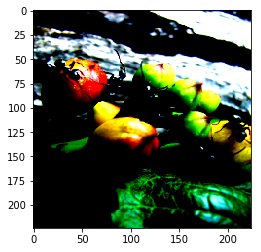

In [72]:
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=False,
                                             num_workers=4)

def show_batch(sample_batched):
    """ Show images from the batch. """
    dict(sample_batched)
    
print("size of the dataset: {}".format(len(dataset_loader)))
    
for batch_id, (sample_batched, labels) in enumerate(dataset_loader):
    print(i_batch)
    print("labels: ", labels)
    # print("dir of sample_batched: ", dir(sample_batched))
    # print("type of sample_batched: ", type(sample_batched))
    print("number of images in a single batch: {}".format(len(sample_batched.numpy())))
    for i_image, images_batch in enumerate(sample_batched):
        # print("type of image: ", type(image))
        # print("image number: {}".format(i_image))
        # plt.imshow(image.numpy().transpose((1, 2, 0)))
        # print("image.numpy(): ", image.numpy())
        print("type of images batch: ", type(images_batch))
        print(images_batch.size())
        print(images_batch[0])
        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

size of the dataset: 61
{'ants': 0, 'bees': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  1,  0,  1])
names:  ['ants', 'bees', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


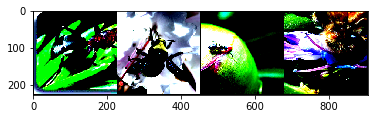

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  1,  1])
names:  ['bees', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


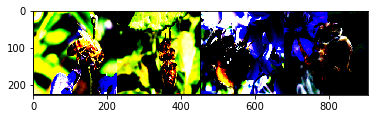

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  0,  0])
names:  ['ants', 'ants', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  1,  0])
names:  ['bees', 'bees', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  1,  1])
names:  ['bees', 'ants', 'bees', 'bees']
number of images in a single batch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample batched shape:  torch.Size([4, 3, 224, 224])


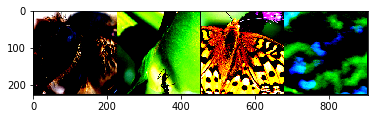

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  1,  0])
names:  ['ants', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


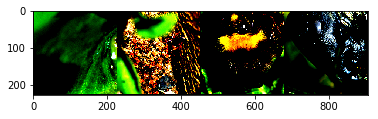

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  1,  1,  1])
names:  ['ants', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


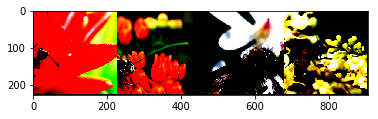

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  1,  1])
names:  ['ants', 'ants', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


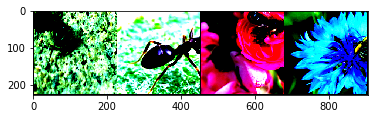

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  1,  0,  0])
names:  ['ants', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  1,  1])
names:  ['ants', 'ants', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


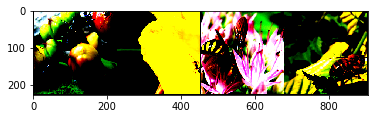

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


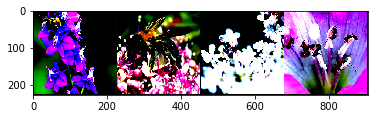

0
labels:  tensor([ 0,  1,  1,  1])
names:  ['ants', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


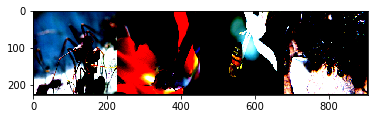

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  1,  0])
names:  ['ants', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  1,  1])
names:  ['bees', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


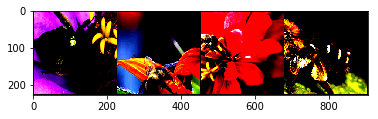

0
labels:  tensor([ 0,  1,  1,  1])
names:  ['ants', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  0,  1])
names:  ['bees', 'ants', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


0
labels:  tensor([ 0,  0,  0,  1])
names:  ['ants', 'ants', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


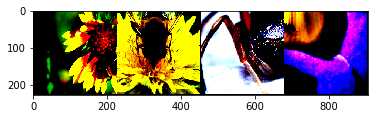

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  0,  1])
names:  ['bees', 'ants', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  1,  0])
names:  ['bees', 'bees', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


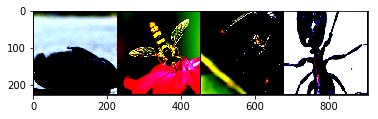

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


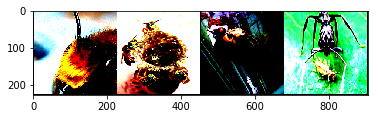

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  0,  1])
names:  ['bees', 'ants', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


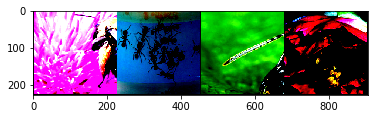

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


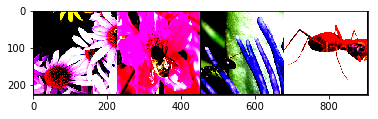

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  0,  0])
names:  ['ants', 'ants', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


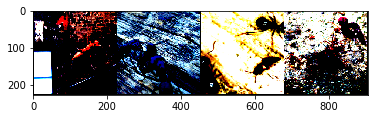

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


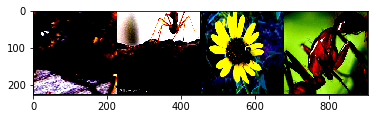

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


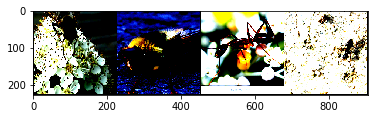

0
labels:  tensor([ 0,  1,  0,  0])
names:  ['ants', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


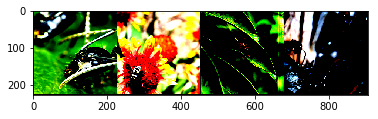

0
labels:  tensor([ 1,  1,  1,  1])
names:  ['bees', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


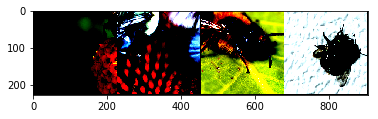

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  1,  0])
names:  ['ants', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


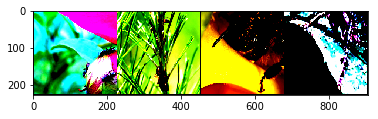

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


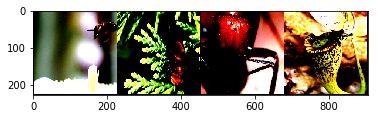

0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample batched shape:  torch.Size([4, 3, 224, 224])


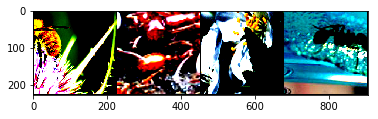

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  0,  1])
names:  ['ants', 'ants', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


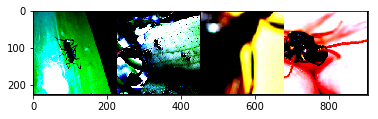

0
labels:  tensor([ 0,  1,  1,  1])
names:  ['ants', 'bees', 'bees', 'bees']
number of images in a single batch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample batched shape:  torch.Size([4, 3, 224, 224])


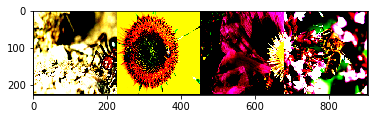

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  1,  1,  0])
names:  ['ants', 'bees', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  1,  0])
names:  ['bees', 'bees', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


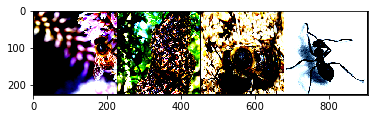

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  1])
names:  ['bees', 'bees', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


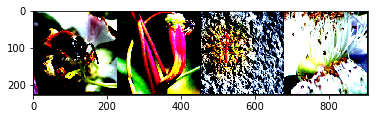

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  0,  0])
names:  ['ants', 'ants', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


0
labels:  tensor([ 1,  1,  1,  0])
names:  ['bees', 'bees', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


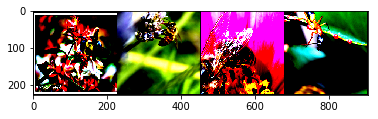

0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  0,  0])
names:  ['ants', 'ants', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


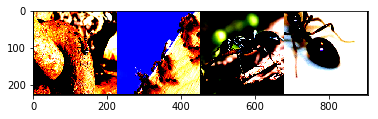

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


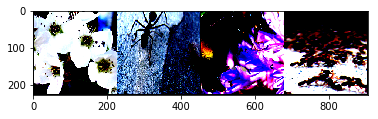

0
labels:  tensor([ 0,  0,  0,  0])
names:  ['ants', 'ants', 'ants', 'ants']
number of images in a single batch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  0,  1])
names:  ['bees', 'ants', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


0
labels:  tensor([ 0,  0,  0,  1])
names:  ['ants', 'ants', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


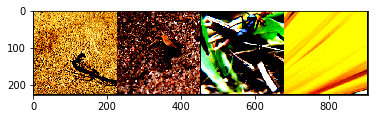

0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample batched shape:  torch.Size([4, 3, 224, 224])


0
labels:  tensor([ 1,  1,  0,  1])
names:  ['bees', 'bees', 'ants', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  0,  0,  0])
names:  ['ants', 'ants', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


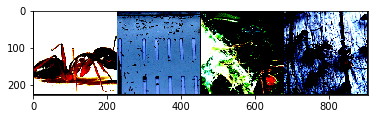

0
labels:  tensor([ 1,  1,  1,  0])
names:  ['bees', 'bees', 'bees', 'ants']
number of images in a single batch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample batched shape:  torch.Size([4, 3, 224, 224])


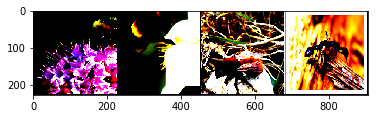

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  1,  1])
names:  ['bees', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


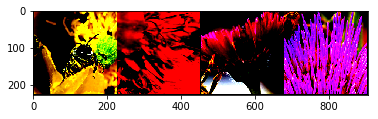

0
labels:  tensor([ 0,  1,  0,  1])
names:  ['ants', 'bees', 'ants', 'bees']
number of images in a single batch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample batched shape:  torch.Size([4, 3, 224, 224])


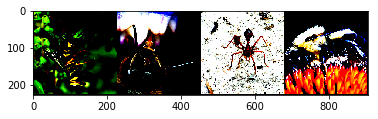

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  0,  0])
names:  ['bees', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


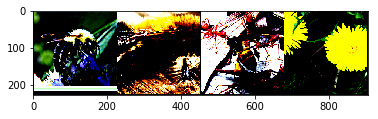

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  1,  1,  1])
names:  ['bees', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


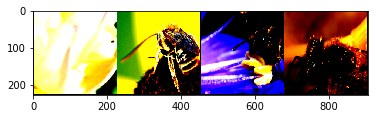

0
labels:  tensor([ 0,  0,  1,  0])
names:  ['ants', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


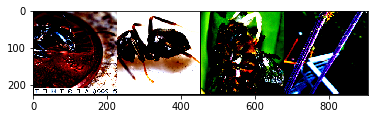

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  1,  1,  0])
names:  ['ants', 'bees', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  1,  1,  1])
names:  ['ants', 'bees', 'bees', 'bees']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 0,  1,  0,  0])
names:  ['ants', 'bees', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


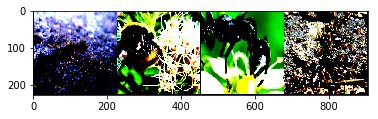

0
labels:  tensor([ 0,  0,  0,  0])
names:  ['ants', 'ants', 'ants', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


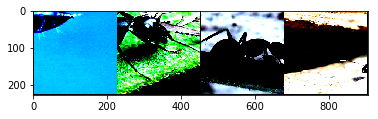

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
labels:  tensor([ 1,  0,  1,  0])
names:  ['bees', 'ants', 'bees', 'ants']
number of images in a single batch: 4
sample batched shape:  torch.Size([4, 3, 224, 224])


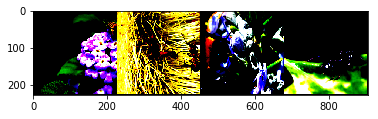

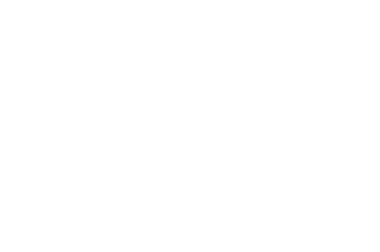

In [87]:
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

def show_batch(sample_batched):
    """ Show images from the batch. """
    dir(sample_batched)
    
print("size of the dataset: {}".format(len(dataset_loader)))

print(hymenoptera_dataset.class_to_idx)
idx_to_class = dict((v, k) for k, v in hymenoptera_dataset.class_to_idx.items())
    
for batch_id, (sample_batched, labels) in enumerate(dataset_loader):
    print(i_batch)
    print("labels: ", labels)
    print("names: ", [idx_to_class[label] for label in labels.numpy()])
    # print("dir of sample_batched: ", dir(sample_batched))
    # print("type of sample_batched: ", type(sample_batched))
    print("number of images in a single batch: {}".format(len(sample_batched.numpy())))
    grid = utils.make_grid(sample_batched)
    print("sample batched shape: ", sample_batched.size())
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
plt.axis('off')
plt.ioff()
plt.show()

In [ ]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels, root_dir="data/"):
        "Initizlization"
        self.labels = labels
        self.list_IDs = list_IDs
        self.root_dir = root_dir

    def __len__(self):
        "Denotes the total number of samples."
        return len(self.list_IDs)

    def __getitem__(self, index):
        "Generates one sample of data."
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = torch.load(root_dir + ID)
        y = self.labels[ID]
        
        return X, y

For an example with training code, please see Transfer Learning tutorial.